In [1]:
import numpy as np
import cv2
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/ahmad/projects/utils/')
from custom_widgets import Browser

In [2]:
browser = Browser(parent_path='/data_sp')
browser.show()

In [3]:
# pick a random frame from the .dat
filepath = browser.path_textbox.value
if 'flir' in filepath.lower():
    preset = 'flir'
elif 'lucid' in filepath.lower():
    preset = 'lucid'
else:
    raise Exception("cannot understand preset from filename")

def readbinary(filepath, start=15, length=None, preset=preset, pick_random=False):
    if length is None:
        if preset=='lucid':
            # multiply by 2 to accomodate the factt that we save distance data at 16bit
            shape = [640, 480]
            length = np.prod(shape) * 2
            dtype = np.uint16
        elif preset=='flir':
            shape = [720, 540]
            length= np.prod(shape)
            dtype = np.uint8

    with open(filepath, 'rb') as file:
        file.seek(start*length)  # Move the pointer
        segment = file.read(length)  # Read the specfied length
    return segment, shape, dtype

def intensity_to_rgba(frame, minval=452, maxval=3065, colormap=cv2.COLORMAP_TURBO):
    new_frame = np.ones((frame.shape[0], frame.shape[1], 4))
    disp_frame = frame.copy().astype("float")
    disp_frame -= minval
    disp_frame[disp_frame < 0] = 0
    disp_frame /= np.abs(maxval - minval)
    disp_frame[disp_frame >= 1] = 1
    disp_frame *= 255
    bgr_frame = cv2.applyColorMap(disp_frame.astype(np.uint8), colormap)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    new_frame[:, :, :3] = rgb_frame
    new_frame = new_frame.astype(np.uint8)
    return new_frame

im, shape, dtype = readbinary(filepath)
im2 = np.frombuffer(im, dtype=dtype)
im3 = im2.reshape(shape[::-1])

if preset == 'lucid:
    slider_values = {'minval': 900, 'maxval': 2300}
else:
    slider_values = {'minval': 0, 'maxval': 115}

def display_frame(minval, maxval, colormap=cv2.COLORMAP_TURBO):
    plt.close('all')
    plt.cla()
    bar = im3
    slider_values['minval'] = minval
    slider_values['maxval'] = maxval
    foo = intensity_to_rgba(bar, minval=minval, maxval=maxval, colormap=colormap)
    plt.imshow(foo[:,:,:3])
    plt.show()


In [6]:
%matplotlib inline
colormap = cv2.COLORMAP_BONE
from ipywidgets import interactive
frame_plot = interactive(display_frame, minval=slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)
output = frame_plot.children[-1]
output.layout.height = '450px'
frame_plot

interactive(children=(IntSlider(value=100, description='minval', max=300, min=-100), IntSlider(value=255, desc…

## Happy with the min and max values - generate an rgb image then move on to cropping

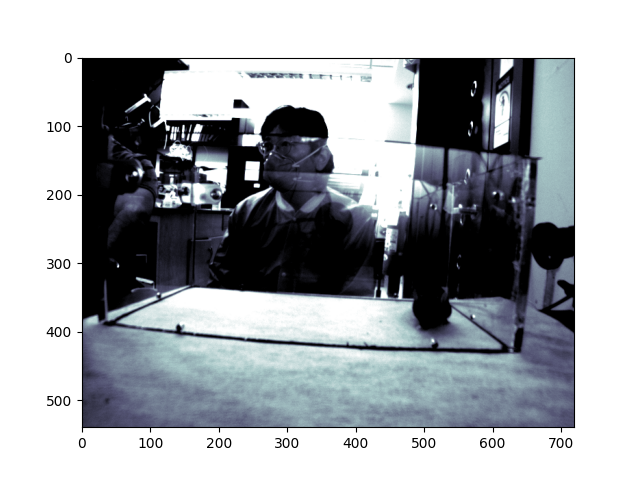

In [5]:
%matplotlib widget
im4 = intensity_to_rgba(im3, minval = slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)[:,:,:3]
fig, ax = plt.subplots()
ax.imshow(im4)
points = []

def onclick(event):
    if event.inaxes:
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'ro')
        fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()



In [21]:
def sort_rectangle_points(points, clockwise=True):
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    
    # Calculate the angles of each point relative to the centroid
    angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    
    # Sort the points based on angles
    sorted_indices = np.argsort(angles)
    
    if not clockwise:
        sorted_indices = sorted_indices[::-1]
    
    sorted_points = points[sorted_indices]
    
    return sorted_points

In [82]:
def rotate_image(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w // 2, h // 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [83]:
def calculate_rotation_angle(coords):
    # Extract coordinates
    x1, y1 = coords[0]
    x2, y2 = coords[1]

    # Calculate the angle of tilt
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

    return angle


In [84]:
points = np.array(points)

In [90]:
points = sort_rectangle_points(points, clockwise=False)

angle = calculate_rotation_angle(points)

# Rotate the image to align the rectangle
rotated_image = rotate_image(im4, angle)



def rotate_points(points, center, angle):
    # Create the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Convert points to homogeneous coordinates for transformation
    ones = np.ones(shape=(len(points), 1))
    points_homogeneous = np.hstack([points, ones])
    
    # Apply the rotation matrix to the points
    rotated_points = M.dot(points_homogeneous.T).T
    
    return rotated_points

def align_rectangle(sorted_points):
    center = tuple(np.mean(sorted_points, axis=0))
    angle = calculate_rotation_angle(sorted_points)
    aligned_points = rotate_points(sorted_points, center, angle)
    return aligned_points

aligned_points = align_rectangle(points)


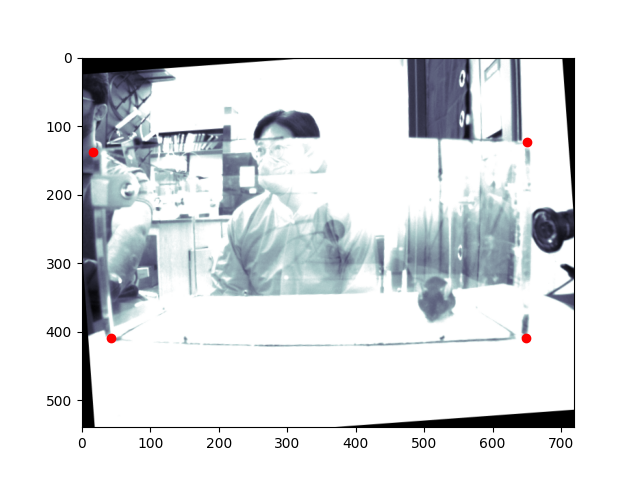

In [91]:
plt.figure()
plt.imshow(rotated_image)
for pt in aligned_points:
    plt.scatter(pt[0], pt[1], color='red')

## Now crop the rectangle

In [1]:
import numpy as np
import cv2
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/ahmad/projects/utils/')
from custom_widgets import Browser

In [2]:
browser = Browser(parent_path='/data_sp')
browser.show()

In [4]:
# pick a random frame from the .dat
filepath = browser.path_textbox.value
if 'flir' in filepath.lower():
    preset = 'flir'
elif 'lucid' in filepath.lower():
    preset = 'lucid'
else:
    raise Exception("cannot understand preset from filename")

def readbinary(filepath, start=15, length=None, preset=preset, pick_random=False):
    if length is None:
        if preset=='lucid':
            # multiply by 2 to accomodate the factt that we save distance data at 16bit
            shape = [640, 480]
            length = np.prod(shape) * 2
            dtype = np.uint16
        elif preset=='flir':
            shape = [720, 540]
            length= np.prod(shape)
            dtype = np.uint8

    with open(filepath, 'rb') as file:
        file.seek(start*length)  # Move the pointer
        segment = file.read(length)  # Read the specfied length
    return segment, shape, dtype

def intensity_to_rgba(frame, minval=452, maxval=3065, colormap=cv2.COLORMAP_TURBO):
    new_frame = np.ones((frame.shape[0], frame.shape[1], 4))
    disp_frame = frame.copy().astype("float")
    disp_frame -= minval
    disp_frame[disp_frame < 0] = 0
    disp_frame /= np.abs(maxval - minval)
    disp_frame[disp_frame >= 1] = 1
    disp_frame *= 255
    bgr_frame = cv2.applyColorMap(disp_frame.astype(np.uint8), colormap)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    new_frame[:, :, :3] = rgb_frame
    new_frame = new_frame.astype(np.uint8)
    return new_frame

im, shape, dtype = readbinary(filepath)
im2 = np.frombuffer(im, dtype=dtype)
im3 = im2.reshape(shape[::-1])


slider_values = {'minval': 900, 'maxval': 2300}
def display_frame(minval, maxval, colormap=cv2.COLORMAP_TURBO):
    plt.close('all')
    plt.cla()
    bar = im3
    slider_values['minval'] = minval
    slider_values['maxval'] = maxval
    foo = intensity_to_rgba(bar, minval=minval, maxval=maxval, colormap=colormap)
    plt.imshow(foo[:,:,:3])
    plt.show()


In [5]:
%matplotlib inline
colormap = cv2.COLORMAP_BONE
from ipywidgets import interactive
frame_plot = interactive(display_frame, minval=100, maxval=255, colormap=colormap)
output = frame_plot.children[-1]
output.layout.height = '450px'
frame_plot

interactive(children=(IntSlider(value=100, description='minval', max=300, min=-100), IntSlider(value=255, desc…

In [21]:
len(points)

5

In [25]:
p = np.array(points)

In [30]:
points

[(32.227272727272734, 387.25974025974017),
 (30.766233766233782, 109.66233766233762),
 (663.3961038961039, 146.18831168831161),
 (635.6363636363636, 420.8636363636363),
 (322.974025974026, 290.8311688311688)]

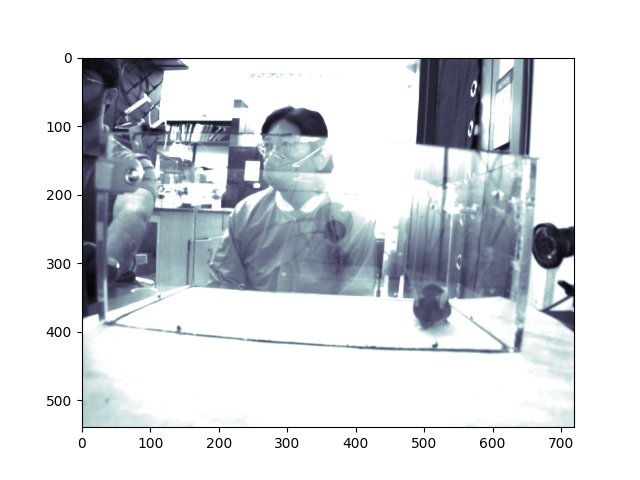

In [42]:
%matplotlib widget
im4 = intensity_to_rgba(im3, minval = slider_values['minval'], maxval=slider_values['maxval'], colormap=colormap)[:,:,:3]
fig, ax = plt.subplots()
ax.imshow(im4)
pcounter = 0
points = []

def onclick(event):
    if event.inaxes:
        if len(points)<4:
            x, y = event.xdata, event.ydata
            points.append((x, y))
            ax.plot(x, y, 'ro')
            fig.canvas.draw()
        else:
            print("Reached maximum of 4 points - re-run if you made a mistake", end='\r')


cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()



In [43]:
def sort_rectangle_points(points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)

    # Calculate the angles of each point relative to the centroid
    angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    
    # Sort the points based on the angles
    sorted_indices = np.argsort(angles)
    
    return points[sorted_indices]
def crop_aligned_rectangle(image, points):
    # Ensure the points are in a NumPy array
    points = np.array(points, dtype=np.float32)

    # Find the bounding box of the points
    rect = cv2.boundingRect(points[:4])
    x, y, w, h = rect

    # Get the transformation matrix for the perspective transform
    dst_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(points, dst_pts)

    # Apply the perspective transformation to the image
    warped = cv2.warpPerspective(image, M, (w, h))

    return warped


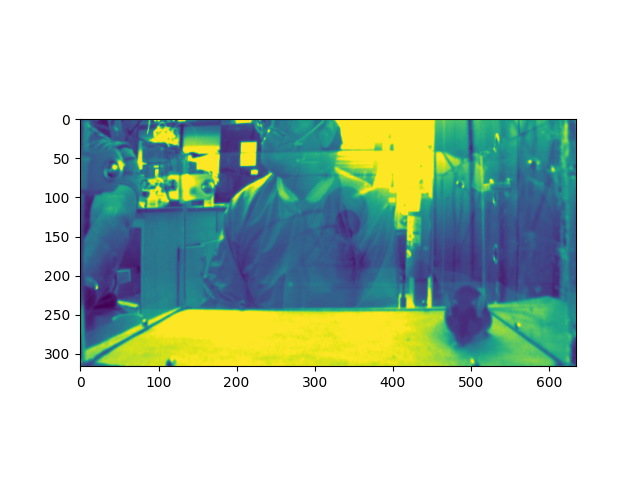

In [45]:
plt.cla()
plt.imshow(warped_cropped)
plt.show()

In [41]:
def proceed():
    # this function contains reading the raw file, applies the perspective warp to each frame, and converts to mp4

IndentationError: expected an indented block (1166523002.py, line 2)